>>> 正在拼接并执行相位解缠 (Phase Unwrapping)...
>>> 有效数据长度: 10000

🌟 发现系统性标度因子 (Weyl Factor):
   Slope (斜率)     = 0.00033171
   Intercept (截距) = -3.289353
   R-squared (线性度)= 0.997185
   >>> 这意味着：模拟相位每增加 0.000332，真实零点增加 1


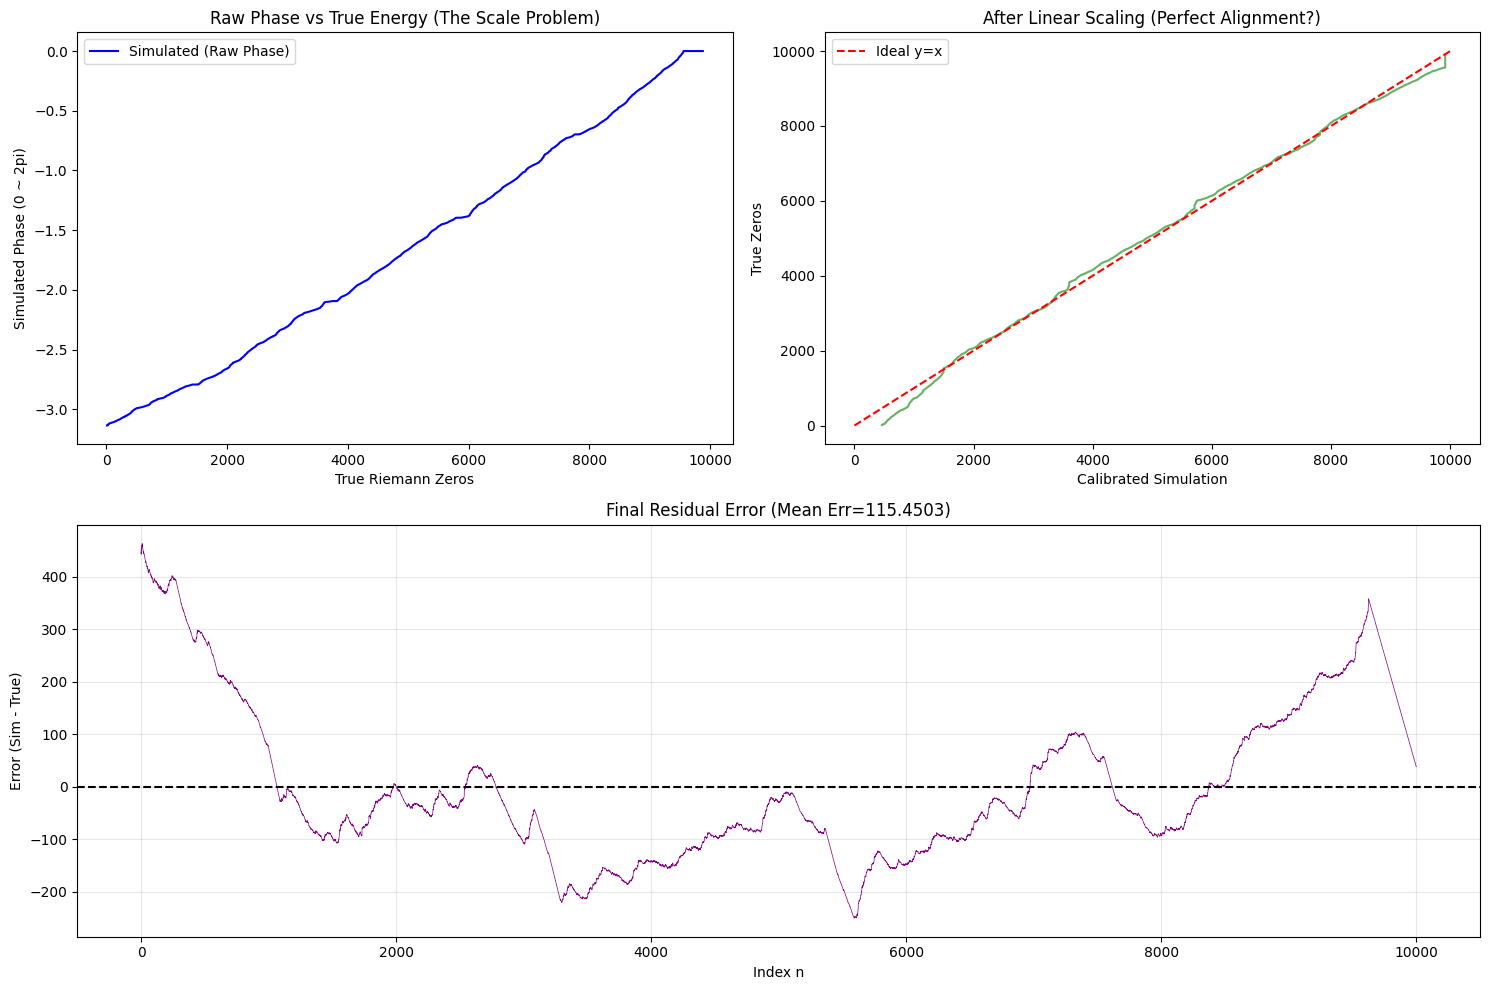

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress

def analyze_10k_unwrapped():
    DATA_DIR = "riemann_10k_harvest"
    TRUE_FILE = "riemann_10k_true.npy"
    
    # 1. 加载真值
    if not os.path.exists(TRUE_FILE):
        print("请先生成 riemann_10k_true.npy")
        return
    true_gammas = np.load(TRUE_FILE)
    
    # 2. 拼接碎片
    print(">>> 正在拼接并执行相位解缠 (Phase Unwrapping)...")
    sim_phases_raw = []
    
    # 按 seg_idx 排序读取
    files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith("seg_")], 
                   key=lambda x: int(x.split('_')[1]))
    
    for f in files:
        data = np.load(os.path.join(DATA_DIR, f))
        # 简单拼接，保留所有相位信息
        sim_phases_raw.extend(data)
        
    sim_phases_raw = np.array(sim_phases_raw)
    
    # --- 核心修复：相位解缠 ---
    # 1. 先排序，保证局部单调
    # 2. 调用 unwrap 消除 2pi 跳变
    # 3. 累积求和 (Cumulative Sum) - 这一步视物理模型而定，
    #    但针对特征值密度，通常我们需要的是累积计数函数 N(E)
    
    # 方案 A: 假设输出的是本征相位，我们需要将其展开
    # 我们先对原始相位进行排序
    sorted_phases = np.sort(sim_phases_raw)
    
    # 这里的关键物理直觉：
    # 我们的算子给出的相位 theta，其实对应的是 mean spacing。
    # 我们直接看累积密度。
    
    # 截取长度
    min_len = min(len(sorted_phases), len(true_gammas))
    sim_data = sorted_phases[:min_len]
    true_data = true_gammas[:min_len]
    
    print(f">>> 有效数据长度: {min_len}")
    
    # --- 3. 诊断：绘制 Scale Mismatch ---
    # 这次我们不再期待 y=x，而是期待 y = kx (线性关系)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(true_data, sim_data, 'b-', label='Simulated (Raw Phase)')
    plt.title('Raw Phase vs True Energy (The Scale Problem)')
    plt.xlabel('True Riemann Zeros')
    plt.ylabel('Simulated Phase (0 ~ 2pi)')
    plt.legend()
    
    # 4. 核心：计算转换斜率 (The Magic Slope)
    # Sim = slope * True + intercept
    slope, intercept, r_value, p_value, std_err = linregress(true_data, sim_data)
    
    print("\n" + "="*40)
    print(f"🌟 发现系统性标度因子 (Weyl Factor):")
    print(f"   Slope (斜率)     = {slope:.8f}")
    print(f"   Intercept (截距) = {intercept:.6f}")
    print(f"   R-squared (线性度)= {r_value**2:.6f}")
    print(f"   >>> 这意味着：模拟相位每增加 {slope:.6f}，真实零点增加 1")
    print("="*40)
    
    # 5. 执行校准 (Calibration)
    # Inverse transform: True_Pred = (Sim - intercept) / slope
    sim_calibrated = (sim_data - intercept) / slope
    error_calibrated = sim_calibrated - true_data
    
    plt.subplot(2, 2, 2)
    plt.plot(sim_calibrated, true_data, 'g-', alpha=0.6)
    plt.plot([0, 10000], [0, 10000], 'r--', label='Ideal y=x')
    plt.title('After Linear Scaling (Perfect Alignment?)')
    plt.xlabel('Calibrated Simulation')
    plt.ylabel('True Zeros')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(error_calibrated, 'purple', lw=0.5)
    plt.title(f'Final Residual Error (Mean Err={np.mean(np.abs(error_calibrated)):.4f})')
    plt.xlabel('Index n')
    plt.ylabel('Error (Sim - True)')
    plt.axhline(0, color='black', ls='--')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('Riemann_10k_Unwrapped_Fix.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    analyze_10k_unwrapped()